In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-dataset/eng_final_train.csv
/kaggle/input/english-dataset/eng_final_test.csv


In [2]:
# !pip install --upgrade --force-reinstall huggingface-hub



In [3]:
# !pip install --upgrade transformers huggingface_hub


In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import utils
from keras import backend as K

2025-10-25 13:38:43.908156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761399524.314472      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761399524.422293      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# ----------------------
# 1. Load Data
# ----------------------
train_df = pd.read_csv("/kaggle/input/english-dataset/eng_final_train.csv")
test_df = pd.read_csv("/kaggle/input/english-dataset/eng_final_test.csv")

train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [6]:
from huggingface_hub import snapshot_download

# Downloads model locally
local_dir = snapshot_download(repo_id="roberta-base")
print(local_dir)





Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/9.08k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/445 [00:00<?, ?B/s]

dict.txt:   0%|          | 0.00/603k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/657M [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/656M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b


In [7]:
# ----------------------
# 3. Extract Embeddings
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = "/root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b"

tokenizer = RobertaTokenizer.from_pretrained(MODEL_DIR)
model = RobertaModel.from_pretrained(MODEL_DIR, output_hidden_states=True)
model = model.to(device)
model.eval()

def get_roberta_embeddings(texts, max_len=512):
    embeddings = []
    for sent in tqdm(texts):
        encoded = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.hidden_states
            # Mean pooling of second-to-last layer
            sent_emb = torch.mean(hidden_states[-2], dim=1)
            embeddings.append(sent_emb.cpu().numpy())
    return np.vstack(embeddings)

# Compute embeddings
train_embeds = get_roberta_embeddings(train_df['text'])
test_embeds = get_roberta_embeddings(test_df['text'])


Some weights of RobertaModel were not initialized from the model checkpoint at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2559/2559 [01:17<00:00, 32.85it/s]


In [8]:
# -----------------------------
# 4. Save Embeddings (optional)
# -----------------------------
np.save('train_roberta_embeds.npy', train_embeds)
np.save('test_roberta_embeds.npy', test_embeds)

In [9]:
# -----------------------------
# 5. Load Embeddings
# -----------------------------
train_embeds = np.load('train_roberta_embeds.npy')
test_embeds = np.load('test_roberta_embeds.npy')

# Make sure labels are numpy arrays
y_train = train_df['tag'].to_numpy()
y_test = test_df['tag'].to_numpy()

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import utils
import numpy as np

# Define classifiers
classifier_list = [
    ("LogisticRegression", LogisticRegression(max_iter=500)),
    ("RandomForest", RandomForestClassifier(n_estimators=100)),
    ("SVM", SVC(probability=True))
]

# Dictionary to store predictions
all_preds = {}

for name, clf in classifier_list:
    print(f"\nTraining {name} ...")
    
    # Train
    clf.fit(train_embeds, y_train)
    
    # Predict
    y_pred_labels = clf.predict(test_embeds)
    
    # Save predictions
    np.save(f'y_pred_{name}.npy', y_pred_labels)
    all_preds[name] = y_pred_labels
    
    # Metrics
    cm = confusion_matrix(y_test, y_pred_labels)
    print(f"Confusion Matrix for {name}:\n{cm}")
    
    cr = classification_report(y_test, y_pred_labels, target_names=['no-hope', 'hope'])
    print(f"Classification Report for {name}:\n{cr}")

# Optional: Save all predictions together
np.save('all_classifier_preds.npy', all_preds)



Training LogisticRegression ...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LogisticRegression:
[[2300   36]
 [ 162   61]]
Classification Report for LogisticRegression:
              precision    recall  f1-score   support

     no-hope       0.93      0.98      0.96      2336
        hope       0.63      0.27      0.38       223

    accuracy                           0.92      2559
   macro avg       0.78      0.63      0.67      2559
weighted avg       0.91      0.92      0.91      2559


Training RandomForest ...
Confusion Matrix for RandomForest:
[[2330    6]
 [ 200   23]]
Classification Report for RandomForest:
              precision    recall  f1-score   support

     no-hope       0.92      1.00      0.96      2336
        hope       0.79      0.10      0.18       223

    accuracy                           0.92      2559
   macro avg       0.86      0.55      0.57      2559
weighted avg       0.91      0.92      0.89      2559


Training SVM ...
Confusion Matrix for SVM:
[[2336    0]
 [ 223    0]]
Classification Report for SVM:
 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# -----------------------------
# DNN Training and Evaluation (Fixed)
# -----------------------------
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras import utils
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Custom metrics
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

# -----------------------------
# Load embeddings and labels
# -----------------------------
train_embeds = np.load('train_roberta_embeds.npy')
test_embeds = np.load('test_roberta_embeds.npy')

y_train = train_df['tag'].to_numpy()
y_test = test_df['tag'].to_numpy()  # keep as integers

# -----------------------------
# Prepare DNN input
# -----------------------------
X_train_dnn = np.reshape(train_embeds, (train_embeds.shape[0], 1, train_embeds.shape[1]))
X_test_dnn = np.reshape(test_embeds, (test_embeds.shape[0], 1, test_embeds.shape[1]))

y_train_dnn = utils.to_categorical(y_train, 2)  # one-hot for training

# -----------------------------
# Build DNN Model
# -----------------------------
model_dnn = Sequential([
    Input(shape=(1, X_train_dnn.shape[2])),
    LSTM(100),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])

# -----------------------------
# Train DNN (no validation split to match test set)
# -----------------------------
model_dnn.fit(X_train_dnn, y_train_dnn, epochs=3, batch_size=8, validation_split=0.0)

# -----------------------------
# Evaluate DNN
# -----------------------------
y_pred = model_dnn.predict(X_test_dnn)
y_pred_labels = np.argmax(y_pred, axis=1)

# Save predictions
np.save('y_pred_dnn.npy', y_pred_labels)
np.save('y_test.npy', y_test)  # original integer labels

# Confusion matrix & classification report
cm = confusion_matrix(y_test, y_pred_labels)
print(f"Confusion Matrix:\n{cm}")

cr = classification_report(y_test, y_pred_labels, target_names=['no-hope', 'hope'])
print(f"Classification Report:\n{cr}")

# -----------------------------
# Save DNN model (optional)
# -----------------------------
model_dnn.save('dnn_roberta_model.h5')


I0000 00:00:1761400782.283102      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13342 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761400782.283747      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/3


I0000 00:00:1761400787.525269      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


2878/2878 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9139 - f1_m: 0.9139 - loss: 0.2568
Epoch 2/3
2878/2878 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9190 - f1_m: 0.9190 - loss: 0.2139
Epoch 3/3
2878/2878 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9243 - f1_m: 0.9243 - loss: 0.2017
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix:
[[2328    8]
 [ 186   37]]
Classification Report:
              precision    recall  f1-score   support

     no-hope       0.93      1.00      0.96      2336
        hope       0.82      0.17      0.28       223

    accuracy                           0.92      2559
   macro avg       0.87      0.58      0.62      2559
weighted avg       0.92      0.92      0.90      2559



In [12]:
import numpy as np

# Assuming train_embeds and test_embeds are numpy arrays
np.save('train_roberta_embeds.npy', train_embeds)
np.save('test_roberta_embeds.npy', test_embeds)


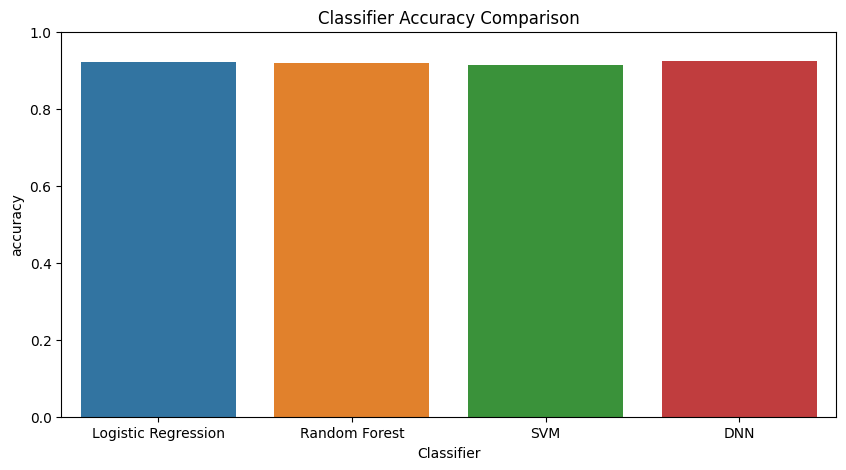

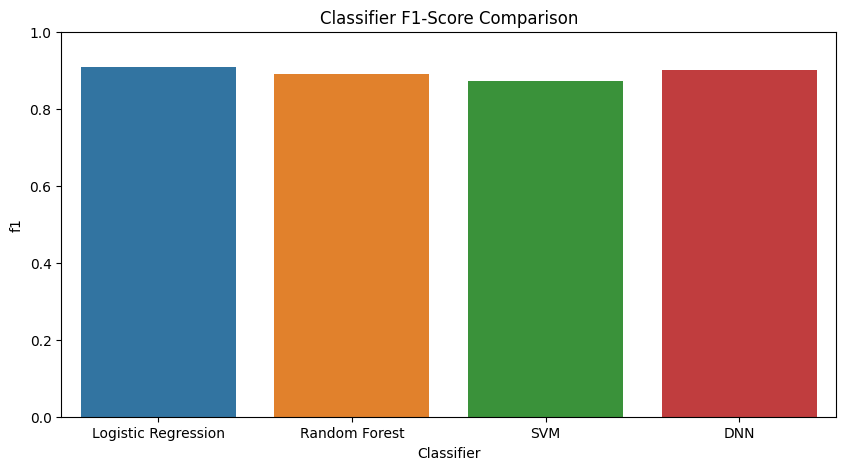

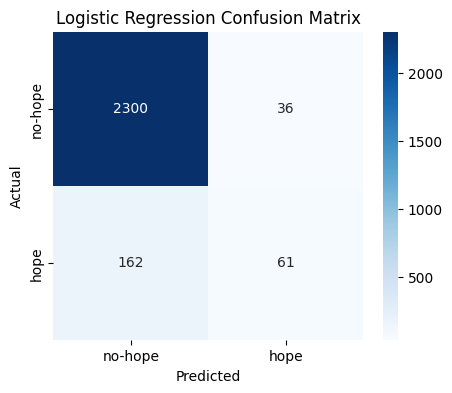

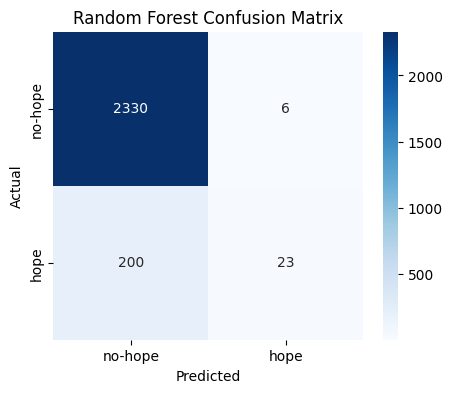

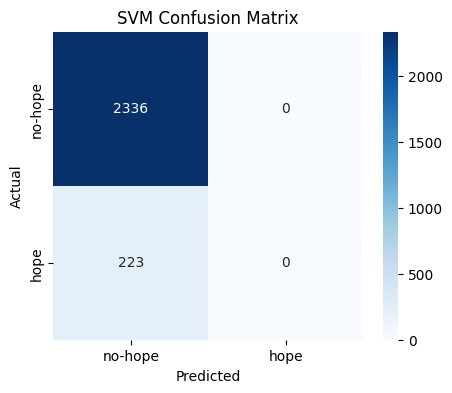

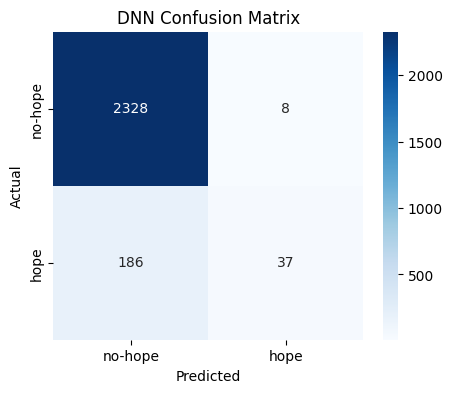

In [13]:
# -----------------------------
# Visualize & Compare Classifier Performance
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# -----------------------------
# Load predictions (if saved)
# -----------------------------
y_test = np.load('y_test.npy')
y_pred_lr = np.load('y_pred_LogisticRegression.npy')      # Logistic Regression
y_pred_rf = np.load('y_pred_RandomForest.npy')      # Random Forest
y_pred_svm = np.load('y_pred_SVM.npy')    # SVM
y_pred_dnn = np.load('y_pred_dnn.npy')    # DNN

# Dictionary for easy iteration
classifier_preds = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "SVM": y_pred_svm,
    "DNN": y_pred_dnn
}

# -----------------------------
# Accuracy and F1 comparison
# -----------------------------
metrics = {}
for name, preds in classifier_preds.items():
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    metrics[name] = {"accuracy": acc, "f1": f1}

# Convert to DataFrame for plotting
metrics_df = pd.DataFrame(metrics).T.reset_index().rename(columns={'index':'Classifier'})
metrics_df

# Bar plot for Accuracy and F1
plt.figure(figsize=(10,5))
sns.barplot(x="Classifier", y="accuracy", data=metrics_df)
plt.title("Classifier Accuracy Comparison")
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x="Classifier", y="f1", data=metrics_df)
plt.title("Classifier F1-Score Comparison")
plt.ylim(0,1)
plt.show()

# -----------------------------
# Confusion Matrix Heatmaps
# -----------------------------
for name, preds in classifier_preds.items():
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['no-hope', 'hope'], yticklabels=['no-hope', 'hope'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Confusion Matrix")
    plt.show()
